**Instead of focusing on Pneumonia vs Non-Pneumonia, I took the opportunity to make a complete EDA on the entire DATA**

# Setup

## Colab-Specific

In [2]:
!pip install matplotlib -U

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [1]:
import os
os.chdir('/content/drive/MyDrive/_Colab/UdacityHealth')

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import io
from tqdm import tqdm
import scipy.stats



ROOT_CSV = 'csv/'
ROOT_DATA = '/data/'

## Download Data

In [3]:
!mkdir ~/.kaggle/
!mv  /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nih-chest-xrays/data -p /data/

100% 42.0G/42.0G [08:19<00:00, 112MB/s]
100% 42.0G/42.0G [08:19<00:00, 90.2MB/s]


In [5]:
!unzip -q /data/data.zip -d /data
!rm /data/data.zip

## Udacity

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import io
from tqdm import tqdm
import scipy.stats


ROOT_CSV = '/data/'
ROOT_DATA = '/data/'
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [ ]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv(ROOT_CSV + 'Data_Entry_2017.csv')
all_xray_df.sample(3)


In [ ]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

# EDA

In [6]:
all_xray_df = pd.read_csv(ROOT_CSV + 'Data_Entry_2017.csv')
sample_df = pd.read_csv(ROOT_CSV +'sample_labels.csv')

## Database Preparation

### Findings cleaning

In [7]:

all_xray_df['Finding Labels'] =  all_xray_df['Finding Labels'].apply(lambda x:x.split('|'))
all_xray_df = pd.concat([all_xray_df,
                        all_xray_df['Finding Labels'].explode().str.get_dummies().sum(level=0).add_prefix('Finding_')
                          ], axis=1)
 
all_xray_df = all_xray_df.drop(['Finding Labels', 'Unnamed: 11'], axis=1)

all_xray_df = all_xray_df.rename(columns={'Image Index':'Image_filename', 'OriginalImage[Width':'Image_width',
                                         'Height]':'Image_height', 'OriginalImagePixelSpacing[x':'ImagePixelSpacing_x',
                                          'y]':'ImagePixelSpacing_y', 'Follow-up #':'Follow-up'})
all_xray_df = all_xray_df.rename(columns={c:c.replace(' ','_') for c in all_xray_df.columns})

disease_col, non_disease_col = [c for c in all_xray_df.columns if 'Finding' in c and c != 'Finding_No_Finding'], ['Finding_No_Finding']
c_findings  = disease_col + non_disease_col
all_xray_df['n_diseases'] = all_xray_df[disease_col].sum(axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  after removing the cwd from sys.path.


#### Check if Dataset is consistent with Non-Finding and no diseases

In [8]:
n_non_diseases_with_diseases = len(all_xray_df.loc[(all_xray_df[non_disease_col[0]] == 1) & (all_xray_df['n_diseases'] > 0) ])
n_nodiseases_with_nofinding = len(all_xray_df.loc[(all_xray_df[non_disease_col[0]] == 0) & (all_xray_df['n_diseases'] == 0) ])

if n_non_diseases_with_diseases == 0: 
  print('All No Findings have no Diseases')
else:
  print(f'Found some items with No Findings and Diseases: {n_non_diseases_with_diseases}')

if n_nodiseases_with_nofinding == 0: 
  print('All no No Findings have some disease')
else:
  print(f'Found some items without neither "No Findings" and no Disease: {n_nodiseases_with_nofinding}')

All No Findings have no Diseases
All no No Findings have some disease


### Data Size

In [9]:
dirs = [d.name for d in os.scandir(ROOT_DATA) if d.is_dir()]
files_dir, files_size = dict(), dict()
for d in dirs:
    for f in os.listdir(ROOT_DATA + '/' + d + '/images/'):
        files_dir[f] = ROOT_DATA + '/' + d + '/images/'
        files_size[f] = os.path.getsize(ROOT_DATA + '/' + d + '/images/' + f) 
        
all_xray_df['dir'] =  all_xray_df['Image_filename'].map(files_dir)
all_xray_df['size'] =  all_xray_df['Image_filename'].map(files_size)


### New DataSources to help EDA

In [10]:
size_dir = all_xray_df.groupby('dir')['size'].sum() / (1024*1024*1024) # transform bytes into Gygabytes
bad_labels = pd.read_csv(ROOT_CSV + 'cxr14_bad_labels.csv').iloc[:,1:]
bad_labels = bad_labels.groupby('Index').sum().reset_index()
bad_labels[['Inverted', 'Not frontal', 'Rotated']] = bad_labels[['Inverted', 'Not frontal', 'Rotated']].apply(lambda x: x > 0).astype(int)

all_xray_df = all_xray_df.merge(bad_labels, left_on='Image_filename', how='left', right_on='Index')
all_xray_df = all_xray_df.drop('Index', axis=1)
all_xray_df = all_xray_df.rename(columns={'Not frontal':'Not_frontal'})
all_xray_df[['Inverted', 'Not_frontal', 'Rotated']] = all_xray_df[['Inverted', 'Not_frontal', 'Rotated']].fillna(0)
n_size_db = all_xray_df.shape[0]

xrays_p_patient = all_xray_df.groupby('Patient_ID').count()['Image_filename']
n_patients = xrays_p_patient.shape[0]

## Data Analysis

### Data Size 

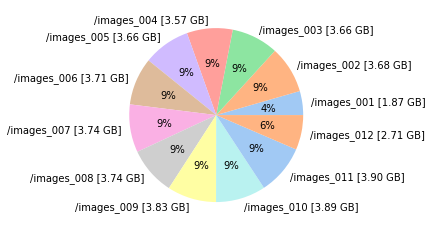

In [11]:
#define data
data = size_dir.values
labels = [f"{x.replace('/data/','').replace('/images/', '')} [{v:.2f} GB]"  for x, v in zip(size_dir.index, data)]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[:len(labels)]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

### Check if all data is present (avoids future problems)

In [12]:
# check if all data in CSV exists:

n_incorrect_images = len(all_xray_df.loc[all_xray_df.dir.isna()])

if n_incorrect_images == 0:
    print('All images in Database exist')
else:
    print(f'Removed from Database {n_incorrect_images} non-existing images')
    all_xray_df.dropna(subset=['dir'], inplace=True)

All images in Database exist


### Check the bad labels

In kaggle there is already a list of the bad labels found in the dataset. In real life, we often need to find external data to validate our findings.
Therefore, I thought it was a valid resource to use here.

In [13]:
bad_label_inverted  = all_xray_df['Inverted'].sum()
bad_label_frontal = all_xray_df['Not_frontal'].sum()
bad_label_rotated = all_xray_df['Rotated'].sum()
bad_label_pneumonia = len(all_xray_df.loc[((all_xray_df.Inverted == 1) | (all_xray_df.Not_frontal == 1) | (all_xray_df.Rotated == 1)) & (all_xray_df.Finding_Pneumonia == 1)])
bad_label_nopneumonia = len(all_xray_df.loc[((all_xray_df.Inverted == 1) | (all_xray_df.Not_frontal == 1) | (all_xray_df.Rotated == 1)) & (all_xray_df.Finding_Pneumonia == 0)])
total_bad_labels = bad_label_inverted + bad_label_frontal + bad_label_rotated

all_xray_df = all_xray_df.loc[(all_xray_df.Inverted == 0) & (all_xray_df.Not_frontal == 0) & (all_xray_df.Rotated == 0) ]

print(f'Total Bad labels:        {total_bad_labels:<5} representing {(total_bad_labels / n_size_db) * 100:.2f}% of total DB ')
print(f'Bad labels Pneumonia:    {bad_label_pneumonia:<5} representing {(bad_label_pneumonia / n_size_db)* 100:.2f}% of total DB and {(bad_label_pneumonia/total_bad_labels) * 100:.2f}% of the bad labels')
print(f'Bad labels No Pneumonia: {bad_label_nopneumonia:<5} representing {(bad_label_nopneumonia / n_size_db)* 100:.2f}% of total DB and {(bad_label_nopneumonia/total_bad_labels) * 100:.2f}% of the bad labels')
print(f'Bad labels Inverted:     {bad_label_inverted:<5} representing {(bad_label_inverted / n_size_db)* 100:.2f}% of total DB and {(bad_label_inverted/total_bad_labels) * 100:.2f}% of the bad labels')
print(f'Bad labels Frontal:      {bad_label_frontal:<5} representing {(bad_label_frontal / n_size_db)* 100:.2f}% of total DB and {(bad_label_frontal/total_bad_labels) * 100:.2f}% of the bad labels')
print(f'Bad labels Rotated:      {bad_label_rotated:<5} representing {(bad_label_rotated / n_size_db)* 100:.2f}% of total DB and {(bad_label_rotated/total_bad_labels) * 100:.2f}% of the bad labels')

all_xray_df = all_xray_df.drop(['Inverted', 'Not_frontal', 'Rotated'], axis=1)


Total Bad labels:        284.0 representing 0.25% of total DB 
Bad labels Pneumonia:    2     representing 0.00% of total DB and 0.70% of the bad labels
Bad labels No Pneumonia: 255   representing 0.23% of total DB and 89.79% of the bad labels
Bad labels Inverted:     62.0  representing 0.06% of total DB and 21.83% of the bad labels
Bad labels Frontal:      171.0 representing 0.15% of total DB and 60.21% of the bad labels
Bad labels Rotated:      51.0  representing 0.05% of total DB and 17.96% of the bad labels


### How many x-rays per Patient

X-Rays per Patient in General

In [14]:
xrays_p_patient.describe()

count    30805.000000
mean         3.639669
std          7.266734
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        184.000000
Name: Image_filename, dtype: float64

X-Rays per Patient with Pneumonia

#### Let us check 75% of our data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


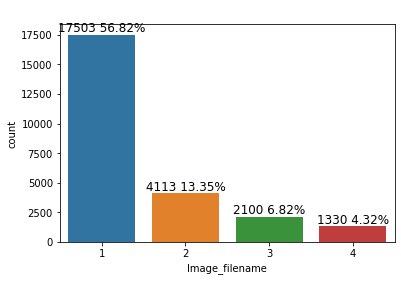

In [15]:
ax = sns.countplot(xrays_p_patient.loc[xrays_p_patient <= 4], x='Image_filename')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()} {p.get_height()/n_patients*100:.2f}%', (p.get_x()+0.4, p.get_height() - 0.15), ha='center', va='bottom', color='black', size=12)
plt.show()

#### Let us check the upper 25%

In [16]:
xrays_p_patient.loc[xrays_p_patient >4].describe()

count    5759.000000
mean       12.983330
std        13.110973
min         5.000000
25%         6.000000
50%         9.000000
75%        14.000000
max       184.000000
Name: Image_filename, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


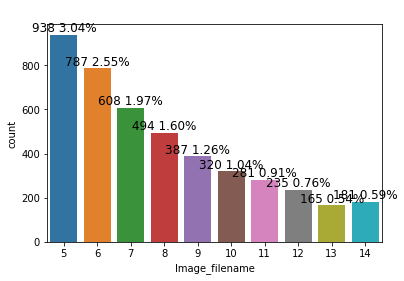

In [17]:
ax = sns.countplot(xrays_p_patient.loc[(xrays_p_patient > 4) & (xrays_p_patient < 15)], x='Image_filename')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()} {p.get_height()/n_patients*100:.2f}%', (p.get_x()+0.4, p.get_height() - 0.15), ha='center', va='bottom', color='black', size=12)
plt.show()

In [18]:
xrays_p_patient.loc[xrays_p_patient >=15].describe()

count    1363.000000
mean       29.257520
std        18.891696
min        15.000000
25%        18.000000
50%        23.000000
75%        33.000000
max       184.000000
Name: Image_filename, dtype: float64

### Age Analysis

In [19]:
all_xray_df['Patient_Age'].describe()

count    111863.000000
mean         46.902685
std          16.835487
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient_Age, dtype: float64

#### We saw that the max age is 414 years old... which means something is clearly wrong... so let us dive into it

In [20]:
all_xray_df.loc[all_xray_df['Patient_Age'] > 100]['Patient_Age'].describe()

count     16.000000
mean     249.312500
std      130.435025
min      148.000000
25%      150.750000
50%      154.500000
75%      412.000000
max      414.000000
Name: Patient_Age, dtype: float64

Given that all the patients above 100 years old (16 patients) have age between 148 - 414, it is safe to assume these are **incorrect**.
So let us substitute these with the following logic:
- if they have already an age from a previous x-ray or from the one after (using Follow-up field), then take that;
- in case they don't have any valid age, take the mean age given from the their diseases;

In [21]:
wrong_ages = all_xray_df.loc[all_xray_df['Patient_Age'] > 100][['Patient_ID','Follow-up'] + c_findings]

def get_age(df, id, follow_n, diseases):
  n_xrays = len(df.loc[df['Patient_ID'] == id])
  if n_xrays > 1:
    follow_to_find = 1 if follow_n == 0 else follow_n - 1
    return df.loc[(df['Patient_ID'] == id) & (df['Follow-up'] == follow_to_find)]['Patient_Age'].values[0]

  means = []
  for i, d in enumerate(c_findings):
    if diseases[i] == 1:
      means.append(df.loc[(df['Patient_Age'] <= 100) & (df[d] ==1 ) ]['Patient_Age'].mean())

  return int(np.average(means) + 0.5)  if len(means) > 0 else int(df.loc[df['Patient_Age'] <= 100]['Patient_Age'].mean() + 0.5)


new_ages = []
for patient in range(len(wrong_ages)):
  new_ages.append(get_age(all_xray_df, wrong_ages.iloc[patient]['Patient_ID'], wrong_ages.iloc[patient]['Follow-up'], list(wrong_ages.iloc[patient][c_findings])))
  
all_xray_df.loc[all_xray_df['Patient_Age'] > 100, 'Patient_Age'] = new_ages

print('Remaining wrong dates: ', len(all_xray_df.loc[all_xray_df['Patient_Age'] > 100]))

Remaining wrong dates:  0


In [22]:
age_diseases = np.array([])

for c in c_findings:
  for gender in ['M', 'F']:
    ages = all_xray_df.loc[(all_xray_df[c] == 1) & (all_xray_df['Patient_Gender'] == gender), 'Patient_Age'].values
    
    if len(age_diseases) == 0:
      age_diseases = np.array([[c] * len(ages), [gender] * len(ages), ages])
    else:
      age_diseases = np.concatenate([np.array([[c] * len(ages), [gender] * len(ages), ages]), age_diseases], axis=1)
    
df_age_disease = pd.DataFrame(age_diseases.T, columns=['Disease', 'Gender', 'Age'])
df_age_disease.Age = pd.to_numeric(df_age_disease.Age)
keys_describe = df_age_disease['Age'].describe().keys()


In [23]:

dis_describe = np.array([])
dis_describe_2 = np.array([])
for c in c_findings:
  tmp = np.array([[c] * len(keys_describe),
                             keys_describe.to_list(),
                             df_age_disease.loc[df_age_disease.Disease == c, 'Age'].describe().to_list()
                             ])
  tmp2 = np.array([c] + df_age_disease.loc[df_age_disease.Disease == c, 'Age'].describe().to_list()).reshape(-1,1)
  if len(dis_describe) == 0:
    dis_describe = tmp
    dis_describe_2 = tmp2
  else:
    dis_describe = np.concatenate([dis_describe, tmp], axis=1)
    dis_describe_2 = np.concatenate([dis_describe_2, tmp2], axis=1)

df_summary_diseases_age = pd.DataFrame(dis_describe.T, columns=['Disease', 'measurement', 'value'])
df_summary_diseases_age.value = pd.to_numeric(df_summary_diseases_age.value)
df_summary_diseases_age = df_summary_diseases_age.loc[df_summary_diseases_age.measurement != 'count']

df_summary_diseases_age_2 = pd.DataFrame(dis_describe_2.T, columns=['Disease'] + keys_describe.to_list())
df_summary_diseases_age_2[keys_describe.to_list()] = df_summary_diseases_age_2[keys_describe.to_list()].apply(pd.to_numeric, errors='coerce')
df_summary_diseases_age_2 = df_summary_diseases_age_2.drop('count', axis=1)


In [24]:
all_xray_df['Patient_Age'].describe()

count    111863.000000
mean         46.874114
std          16.592860
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient_Age, dtype: float64

In [25]:
all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 1, 'Patient_Age'].describe()

count    1429.000000
mean       44.717285
std        17.612698
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient_Age, dtype: float64

In [26]:
all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 0, 'Patient_Age'].describe()

count    110434.000000
mean         46.902023
std          16.577498
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient_Age, dtype: float64

#### Historigram of Age with all patients

<AxesSubplot:xlabel='Patient_Age', ylabel='Count'>

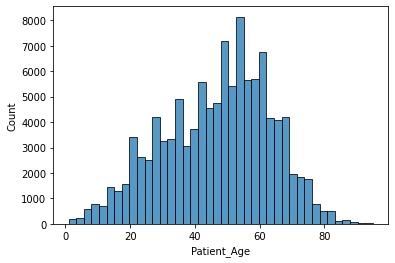

In [27]:
sns.histplot(data=all_xray_df, x="Patient_Age", bins=40)

#### Historigram of Age according to Sex (all cases)

<AxesSubplot:xlabel='Patient_Age', ylabel='Count'>

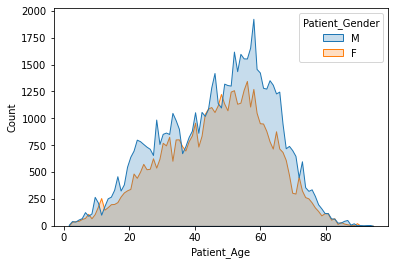

In [28]:
sns.histplot(all_xray_df, x="Patient_Age", hue="Patient_Gender", element="poly")


#### Historigram of Age according to Sex (no-Pneumonia)

<AxesSubplot:xlabel='Patient_Age', ylabel='Count'>

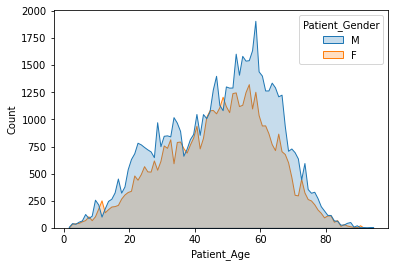

In [29]:
sns.histplot(all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 0], x="Patient_Age", hue="Patient_Gender", element="poly")


#### Historigram of Age according to Sex (Pneumonia)

<AxesSubplot:xlabel='Patient_Age', ylabel='Count'>

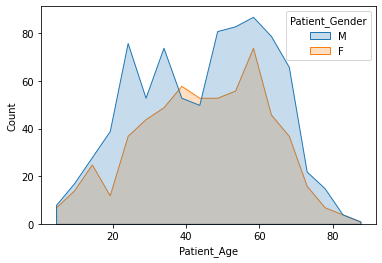

In [30]:
sns.histplot(all_xray_df.loc[all_xray_df['Finding_Pneumonia'] == 1], x="Patient_Age", hue="Patient_Gender", element="poly")


#### Historigram of Age according to Sex vs Diseases

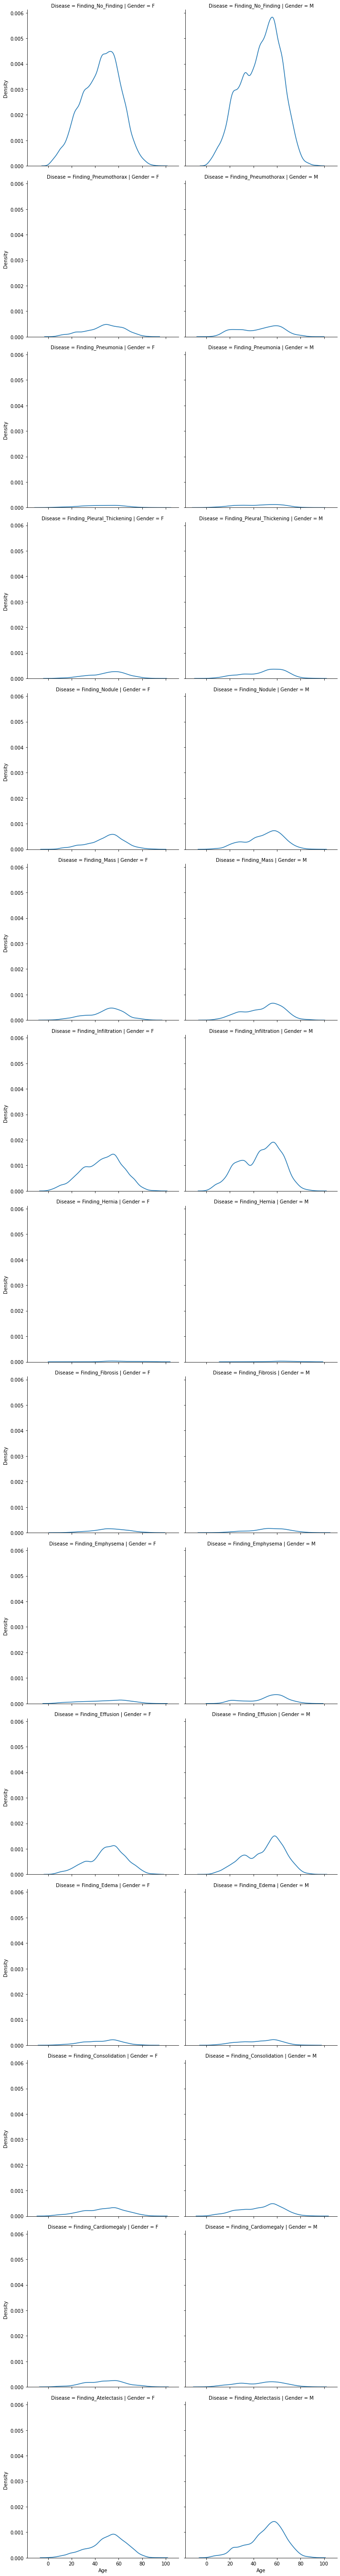

In [31]:
sns.displot(data=df_age_disease, x="Age", col="Gender", row='Disease', kind="kde")

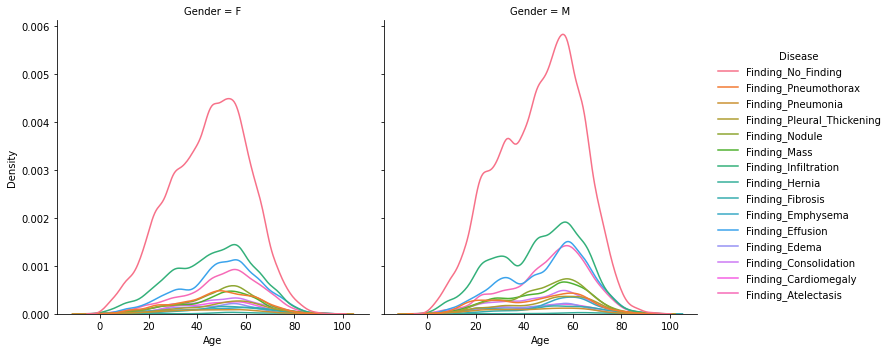

In [32]:
sns.displot(data=df_age_disease, x="Age", col="Gender", hue='Disease', kind="kde")

#### Removing "No Finding" in order to compare all ages

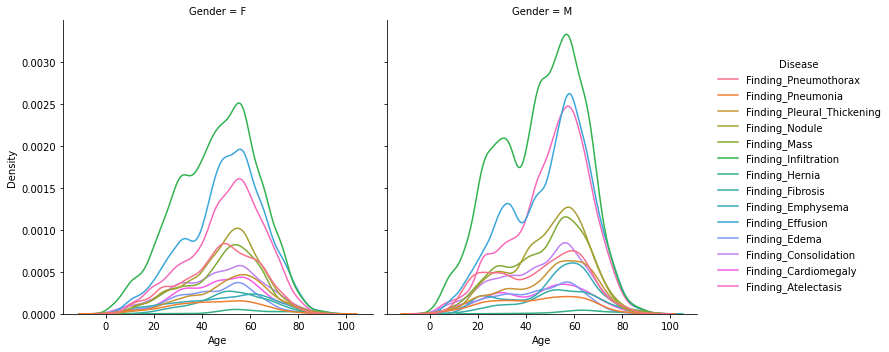

In [33]:
sns.displot(data=df_age_disease.loc[df_age_disease.Disease != 'Finding_No_Finding'], x="Age", col="Gender", hue='Disease', kind="kde")

#### I can't see a is a clear difference from No Finding vs Disease, so let us confirm that there isn't one analytically

In [34]:
print(f'{"No Disease".center(10)} | {"Disease".center(10)} | {"Diff".center(10)} | {"Diff %".center(10)} | {"Cat":>10} ')
print('—'*(60 + 6))
for i,(no, dis) in enumerate(zip(
                df_age_disease.loc[df_age_disease.Disease == 'Finding_No_Finding', 'Age'].describe(), 
                df_age_disease.loc[df_age_disease.Disease != 'Finding_No_Finding', 'Age'].describe())):
  print(f"{no:10.2f} | {dis:10.2f} | {dis-no:10.2f} | {(dis-no)/no*100:9.2f}% | {keys_describe[i]+' Age' :>10}")
  

No Disease |  Disease   |    Diff    |   Diff %   |        Cat 
——————————————————————————————————————————————————————————————————
  60190.00 |   81042.00 |   20852.00 |     34.64% |  count Age
     45.74 |      48.34 |       2.60 |      5.69% |   mean Age
     16.52 |      16.59 |       0.07 |      0.42% |    std Age
      1.00 |       1.00 |       0.00 |      0.00% |    min Age
     33.00 |      36.00 |       3.00 |      9.09% |    25% Age
     47.00 |      51.00 |       4.00 |      8.51% |    50% Age
     58.00 |      60.00 |       2.00 |      3.45% |    75% Age
     95.00 |      94.00 |      -1.00 |     -1.05% |    max Age


#### Now I would like to check the distribution of all the Diseases, to see if there's any Disease with a significant difference in age

<AxesSubplot:xlabel='value', ylabel='measurement'>

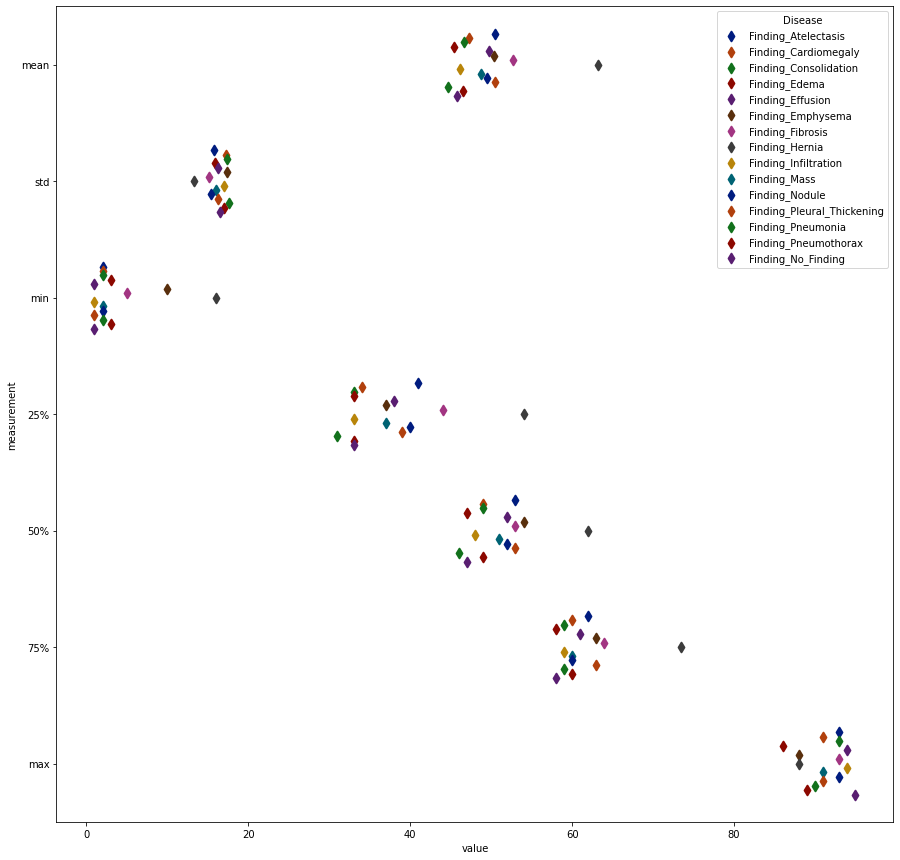

In [35]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

sns.pointplot(x="value", y="measurement", hue="Disease",
              data=df_summary_diseases_age, dodge=.8 - .8 / 3,
              join=False, palette="dark", markers="d", scale=1, ci=None)

In [36]:
df_summary_diseases_age_2.sort_values('mean', ascending=False)

,Disease,mean,std,min,25%,50%,75%,max
7,Finding_Hernia,63.211454,13.353573,16.0,54.0,62.0,73.5,88.0
6,Finding_Fibrosis,52.702911,15.088866,5.0,44.0,53.0,64.0,93.0
0,Finding_Atelectasis,50.487048,15.744356,2.0,41.0,53.0,62.0,93.0
11,Finding_Pleural_Thickening,50.466706,16.314524,1.0,39.0,53.0,63.0,91.0
5,Finding_Emphysema,50.332935,17.337540,10.0,37.0,54.0,63.0,88.0
4,Finding_Effusion,49.743509,16.236042,1.0,38.0,52.0,61.0,94.0
10,Finding_Nodule,49.473884,15.332715,2.0,40.0,52.0,60.0,93.0
9,Finding_Mass,48.714657,16.021738,2.0,37.0,51.0,60.0,91.0
1,Finding_Cardiomegaly,47.273514,17.245141,2.0,34.0,49.0,60.0,91.0
2,Finding_Consolidation,46.640129,17.328087,2.0,33.0,49.0,59.0,93.0


In [37]:
hernia = df_summary_diseases_age_2.loc[df_summary_diseases_age_2.Disease == 'Finding_Hernia']
no_hernia = df_summary_diseases_age_2.loc[df_summary_diseases_age_2.Disease != 'Finding_Hernia']
no_hernia_diff = no_hernia.copy()
no_hernia_diff.iloc[:,1:] = hernia.iloc[:,1:].values - no_hernia.iloc[:,1:].values
no_hernia_diff[no_hernia_diff.columns[1:] + '_inc%'] = (hernia.iloc[:,1:].values - no_hernia.iloc[:,1:].values) * 100 / no_hernia.iloc[:,1:].values
no_hernia_diff

,Disease,mean,std,min,25%,50%,75%,max,mean_inc%,std_inc%,min_inc%,25%_inc%,50%_inc%,75%_inc%,max_inc%
0,Finding_Atelectasis,12.724405,-2.390783,14.0,13.0,9.0,11.5,-5.0,25.203306,-15.185015,700.000000,31.707317,16.981132,18.548387,-5.376344
1,Finding_Cardiomegaly,15.937940,-3.891567,14.0,20.0,13.0,13.5,-3.0,33.714313,-22.566168,700.000000,58.823529,26.530612,22.500000,-3.296703
2,Finding_Consolidation,16.571325,-3.974514,14.0,21.0,13.0,14.5,-5.0,35.530187,-22.936830,700.000000,63.636364,26.530612,24.576271,-5.376344
3,Finding_Edema,17.739764,-2.482105,13.0,21.0,15.0,15.5,2.0,39.012766,-15.674129,433.333333,63.636364,31.914894,26.724138,2.325581
4,Finding_Effusion,13.467945,-2.882468,15.0,16.0,10.0,12.5,-6.0,27.074779,-17.753517,1500.000000,42.105263,19.230769,20.491803,-6.382979
5,Finding_Emphysema,12.878519,-3.983967,6.0,17.0,8.0,10.5,0.0,25.586663,-22.978848,60.000000,45.945946,14.814815,16.666667,0.000000
6,Finding_Fibrosis,10.508542,-1.735293,11.0,10.0,9.0,9.5,-5.0,19.939206,-11.500484,220.000000,22.727273,16.981132,14.843750,-5.376344
8,Finding_Infiltration,17.030015,-3.665816,15.0,21.0,14.0,14.5,-6.0,36.876321,-21.539055,1500.000000,63.636364,29.166667,24.576271,-6.382979
9,Finding_Mass,14.496797,-2.668164,14.0,17.0,11.0,13.5,-3.0,29.758594,-16.653401,700.000000,45.945946,21.568627,22.500000,-3.296703
10,Finding_Nodule,13.737570,-1.979142,14.0,14.0,10.0,13.5,-5.0,27.767316,-12.907969,700.000000,35.000000,19.230769,22.500000,-5.376344


In [38]:
df_summary_diseases_age_2.sort_values('mean', ascending=True)

,Disease,mean,std,min,25%,50%,75%,max
12,Finding_Pneumonia,44.717285,17.612698,2.0,31.0,46.0,59.0,90.0
3,Finding_Edema,45.471690,15.835678,3.0,33.0,47.0,58.0,86.0
14,Finding_No_Finding,45.738079,16.520461,1.0,33.0,47.0,58.0,95.0
8,Finding_Infiltration,46.181438,17.019389,1.0,33.0,48.0,59.0,94.0
13,Finding_Pneumothorax,46.463442,17.046268,3.0,33.0,49.0,60.0,89.0
2,Finding_Consolidation,46.640129,17.328087,2.0,33.0,49.0,59.0,93.0
1,Finding_Cardiomegaly,47.273514,17.245141,2.0,34.0,49.0,60.0,91.0
9,Finding_Mass,48.714657,16.021738,2.0,37.0,51.0,60.0,91.0
10,Finding_Nodule,49.473884,15.332715,2.0,40.0,52.0,60.0,93.0
4,Finding_Effusion,49.743509,16.236042,1.0,38.0,52.0,61.0,94.0


In [39]:
pneumonia = df_summary_diseases_age_2.loc[df_summary_diseases_age_2.Disease == 'Finding_Pneumonia']
no_pneumonia = df_summary_diseases_age_2.loc[df_summary_diseases_age_2.Disease != 'Finding_Pneumonia']
no_pneumonia_diff = no_pneumonia.copy()
no_pneumonia_diff.iloc[:,1:] = pneumonia.iloc[:,1:].values - no_pneumonia.iloc[:,1:].values
no_pneumonia_diff[no_pneumonia_diff.columns[1:] + '_inc%'] = (pneumonia.iloc[:,1:].values - no_pneumonia.iloc[:,1:].values) * 100 / no_pneumonia.iloc[:,1:].values
no_pneumonia_diff.sort_values('mean')

,Disease,mean,std,min,25%,50%,75%,max,mean_inc%,std_inc%,min_inc%,25%_inc%,50%_inc%,75%_inc%,max_inc%
7,Finding_Hernia,-18.494169,4.259125,-14.0,-23.0,-16.0,-14.5,2.0,-29.257623,31.895018,-87.500000,-42.592593,-25.806452,-19.727891,2.272727
6,Finding_Fibrosis,-7.985627,2.523832,-3.0,-13.0,-7.0,-5.0,-3.0,-15.152155,16.726453,-60.000000,-29.545455,-13.207547,-7.812500,-3.225806
0,Finding_Atelectasis,-5.769764,1.868342,0.0,-10.0,-7.0,-3.0,-3.0,-11.428205,11.866740,0.000000,-24.390244,-13.207547,-4.838710,-3.225806
11,Finding_Pleural_Thickening,-5.749421,1.298174,1.0,-8.0,-7.0,-4.0,-1.0,-11.392504,7.957165,100.000000,-20.512821,-13.207547,-6.349206,-1.098901
5,Finding_Emphysema,-5.615650,0.275158,-8.0,-6.0,-8.0,-4.0,2.0,-11.157009,1.587063,-80.000000,-16.216216,-14.814815,-6.349206,2.272727
4,Finding_Effusion,-5.026224,1.376656,1.0,-7.0,-6.0,-2.0,-4.0,-10.104281,8.479014,100.000000,-18.421053,-11.538462,-3.278689,-4.255319
10,Finding_Nodule,-4.756599,2.279983,0.0,-9.0,-6.0,-1.0,-3.0,-9.614364,14.870051,0.000000,-22.500000,-11.538462,-1.666667,-3.225806
9,Finding_Mass,-3.997372,1.590960,0.0,-6.0,-5.0,-1.0,-1.0,-8.205687,9.930012,0.000000,-16.216216,-9.803922,-1.666667,-1.098901
1,Finding_Cardiomegaly,-2.556229,0.367557,0.0,-3.0,-3.0,-1.0,-1.0,-5.407317,2.131367,0.000000,-8.823529,-6.122449,-1.666667,-1.098901
2,Finding_Consolidation,-1.922844,0.284611,0.0,-2.0,-3.0,0.0,-3.0,-4.122724,1.642482,0.000000,-6.060606,-6.122449,0.000000,-3.225806


### Gender

1.0    16613
0.0    14160
Name: Patient_Gender_cat, dtype: int64
where 1 = Male and 0 = Female


<AxesSubplot:title={'center':'Patients Gender'}, ylabel='Patient_Gender_cat'>

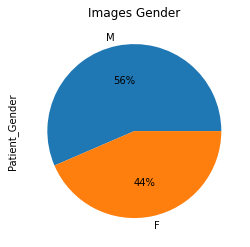

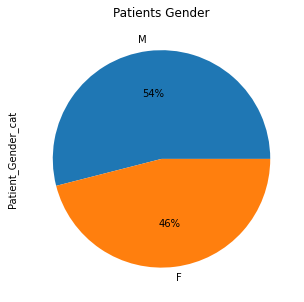

In [40]:
all_xray_df['Patient_Gender_cat'] = all_xray_df['Patient_Gender'].map({'M':1, 'F':0})
all_xray_df['Patient_Gender'].value_counts().plot(kind='pie', autopct='%1.0f%%', labels=['M','F'], title='Images Gender')
plt.figure(figsize=(5, 5))
print(all_xray_df.groupby('Patient_ID')['Patient_Gender_cat'].mean().value_counts())
print('where 1 = Male and 0 = Female')
all_xray_df.groupby('Patient_ID')['Patient_Gender_cat'].mean().value_counts().plot(kind='pie', autopct='%1.0f%%', labels=['M','F'], title='Patients Gender')

#### Check if there are any inconsistencies

In [41]:
check = all_xray_df.groupby('Patient_ID')['Patient_Gender_cat'].agg(['min', 'max'])
check['diff'] =  check['max'] - check['min']
if len(check['diff'].unique()) == 1 and check['diff'].unique()[0] == 0: 
  print('There are no gender inconsistencies')
else:
  print('There are some inconsistencies. IDs: ')
  print(check.loc[check.diff != 0, 'Patient_ID'].values)


There are no gender inconsistencies


#### Check statistical difference of Age vs Gender

In [42]:
print(f'{"M".center(10)} | {"F".center(10)} | {"Diff".center(10)} | {"Diff %".center(10)} | {"Cat":>10} ')
print('—'*(60 + 6))
for i,(m, f) in enumerate(zip(all_xray_df.loc[all_xray_df.Patient_Gender == 'M', 'Patient_Age'].describe(), 
                all_xray_df.loc[all_xray_df.Patient_Gender == 'F', 'Patient_Age'].describe())):
  print(f"{m:10.2f} | {f:10.2f} | {m-f:10.2f} | {(m-f)/m*100:9.2f}% | {keys_describe[i]+' Age' :>10}")


    M      |     F      |    Diff    |   Diff %   |        Cat 
——————————————————————————————————————————————————————————————————
  63181.00 |   48682.00 |   14499.00 |     22.95% |  count Age
     47.16 |      46.51 |       0.65 |      1.38% |   mean Age
     16.88 |      16.21 |       0.67 |      3.99% |    std Age
      1.00 |       1.00 |       0.00 |      0.00% |    min Age
     34.00 |      35.00 |      -1.00 |     -2.94% |    25% Age
     50.00 |      48.00 |       2.00 |      4.00% |    50% Age
     60.00 |      58.00 |       2.00 |      3.33% |    75% Age
     94.00 |      95.00 |      -1.00 |     -1.06% |    max Age


#### Check Gender vs Diseases

In [43]:
change_label = lambda txt, val1, val2: txt.replace('Finding_', '') + f' {(val1-val2)*100/(val1+val2):.0f}% diff'
gender_vs_diseases = df_age_disease.groupby(['Disease','Gender']).count().reset_index().rename(columns={'Age':'count'})

new_labels = {c:change_label(c, 
                             gender_vs_diseases.loc[(gender_vs_diseases.Disease == c ) & (gender_vs_diseases.Gender == 'M' ), 'count'].values[0],
                             gender_vs_diseases.loc[(gender_vs_diseases.Disease == c ) & (gender_vs_diseases.Gender == 'F' ), 'count'].values[0]
                             ) 
                             for c in gender_vs_diseases.Disease.unique()}

gender_vs_diseases.Disease = gender_vs_diseases.Disease.map(new_labels)
gender_vs_diseases

,Disease,Gender,count
0,Atelectasis 20% diff,F,4646
1,Atelectasis 20% diff,M,6897
2,Cardiomegaly -6% diff,F,1468
3,Cardiomegaly -6% diff,M,1307
4,Consolidation 14% diff,F,1999
5,Consolidation 14% diff,M,2661
6,Edema 5% diff,F,1096
7,Edema 5% diff,M,1200
8,Effusion 12% diff,F,5865
9,Effusion 12% diff,M,7422


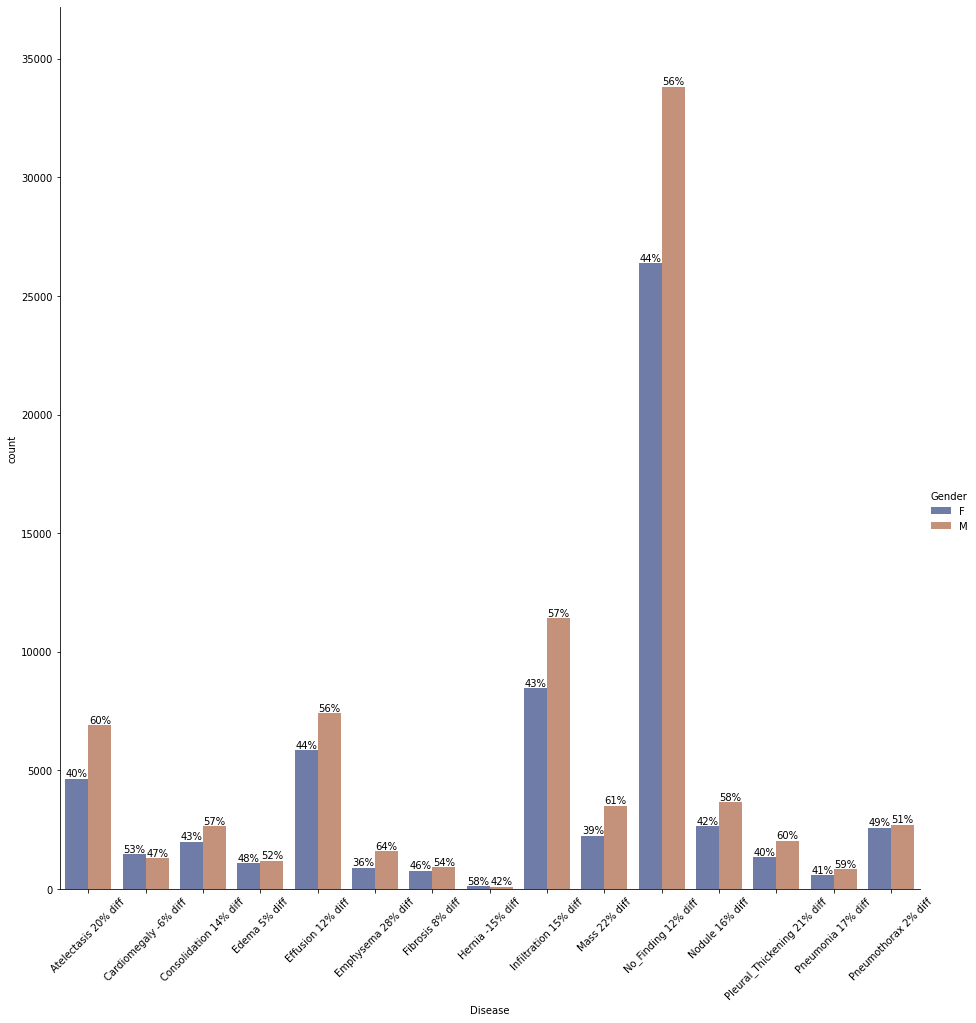

In [44]:
g = sns.catplot(
    data=gender_vs_diseases, kind="bar",
    x="Disease", y="count", hue="Gender",
    ci="sd", palette="dark", alpha=.6, height=13
)
plt.xticks(rotation=45)

for ax in g.axes.ravel():
    
    # add annotations
    containers = ax.containers
    labels_1 = [f'{v1.get_height()/(v1.get_height() + v2.get_height())*100:.0f}%' for v1, v2  in zip(containers[0], containers[1])]
    labels_2 = [f'{v2.get_height()/(v1.get_height() + v2.get_height())*100:.0f}%' for v1, v2  in zip(containers[0], containers[1])]
    ax.bar_label(containers[0], labels=labels_1, label_type='edge')
    ax.bar_label(containers[1], labels=labels_2, label_type='edge')
    
    ax.margins(y=0.1)

plt.show()



### Diseases Analysis 

In [45]:
count_diseases = all_xray_df[c_findings].sum()

count_diseases.index = [c.replace('Finding_','') + f' {v/n_size_db*100:.0f}%' for c, v in zip(count_diseases.index, count_diseases.values)]
count_diseases.sort_values()

Hernia 0%                  227
Pneumonia 1%              1429
Fibrosis 2%               1683
Edema 2%                  2296
Emphysema 2%              2511
Cardiomegaly 2%           2775
Pleural_Thickening 3%     3379
Consolidation 4%          4660
Pneumothorax 5%           5293
Mass 5%                   5772
Nodule 6%                 6318
Atelectasis 10%          11543
Effusion 12%             13287
Infiltration 18%         19869
No_Finding 54%           60190
dtype: int64

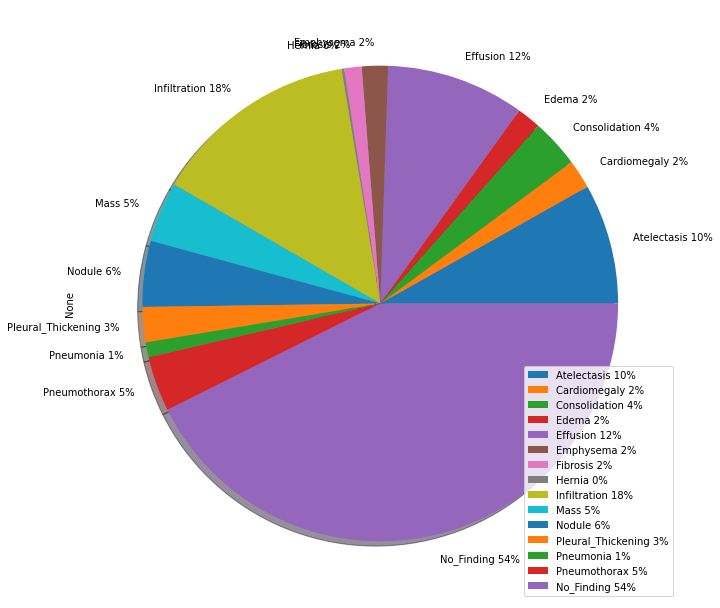

In [46]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
ax = count_diseases.plot(kind='pie', shadow=True, legend=True,)

plt.tight_layout()
plt.show()


Disease only distribution

In [47]:
count_diseases_only = all_xray_df[disease_col].sum()
n_size_db_diseases_only = count_diseases_only.sum()

count_diseases_only.index = [c.replace('Finding_','') + f' {v/n_size_db_diseases_only*100:.0f}%' for c, v in zip(count_diseases_only.index, count_diseases_only.values)]
count_diseases_only.sort_values()

Hernia 0%                  227
Pneumonia 2%              1429
Fibrosis 2%               1683
Edema 3%                  2296
Emphysema 3%              2511
Cardiomegaly 3%           2775
Pleural_Thickening 4%     3379
Consolidation 6%          4660
Pneumothorax 7%           5293
Mass 7%                   5772
Nodule 8%                 6318
Atelectasis 14%          11543
Effusion 16%             13287
Infiltration 25%         19869
dtype: int64

In [48]:
n_size_db_diseases_only, all_xray_df.shape

(81042, (111863, 29))

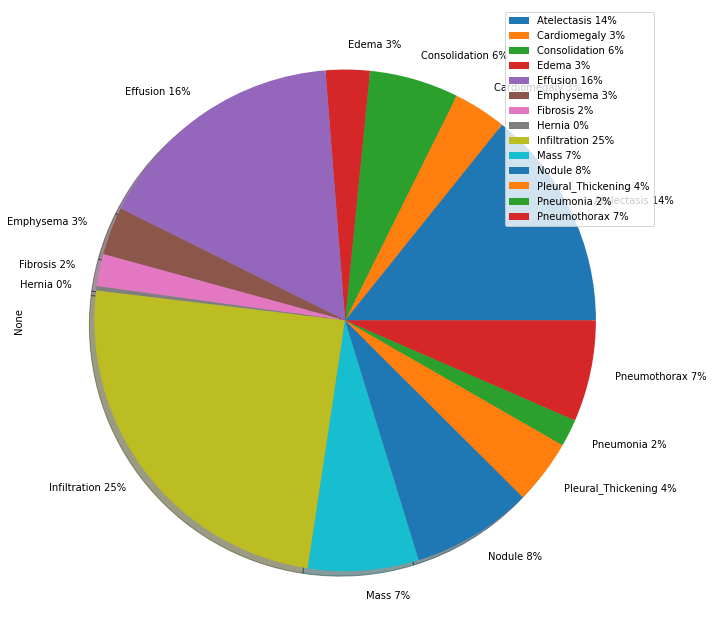

In [49]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)
ax = count_diseases_only.plot(kind='pie', shadow=True, legend=True,)

plt.tight_layout()
plt.show()


#### Let us check Correlation between Diseases
To do that, first step is to combine the diseases in each patient, so that we have grouped the diseases per patient to check if there are any diseases which are common to come together

In [50]:
grouped_patient_diseases = all_xray_df[['Patient_ID'] + c_findings].groupby('Patient_ID').agg(np.sum).reset_index()
for c in c_findings:
  grouped_patient_diseases[c] = grouped_patient_diseases[c].apply(lambda x:1 if x>=1 else 0)

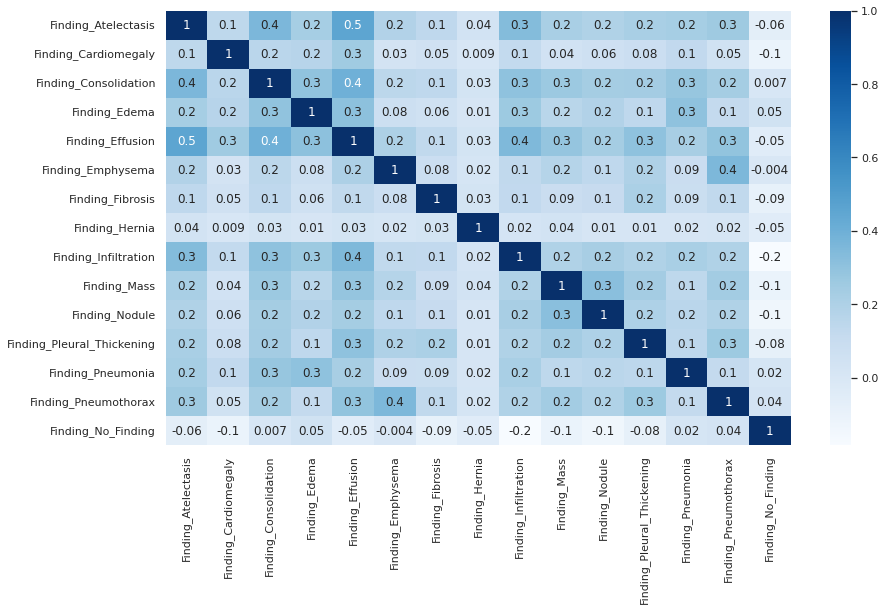

In [51]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = grouped_patient_diseases[c_findings].corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

### Visualize Training Data (images)

In [52]:
all_xray_df['View_Position'].value_counts()

PA    67235
AP    44628
Name: View_Position, dtype: int64

#### Visualize a random sample from DataSet and analise it's patterns

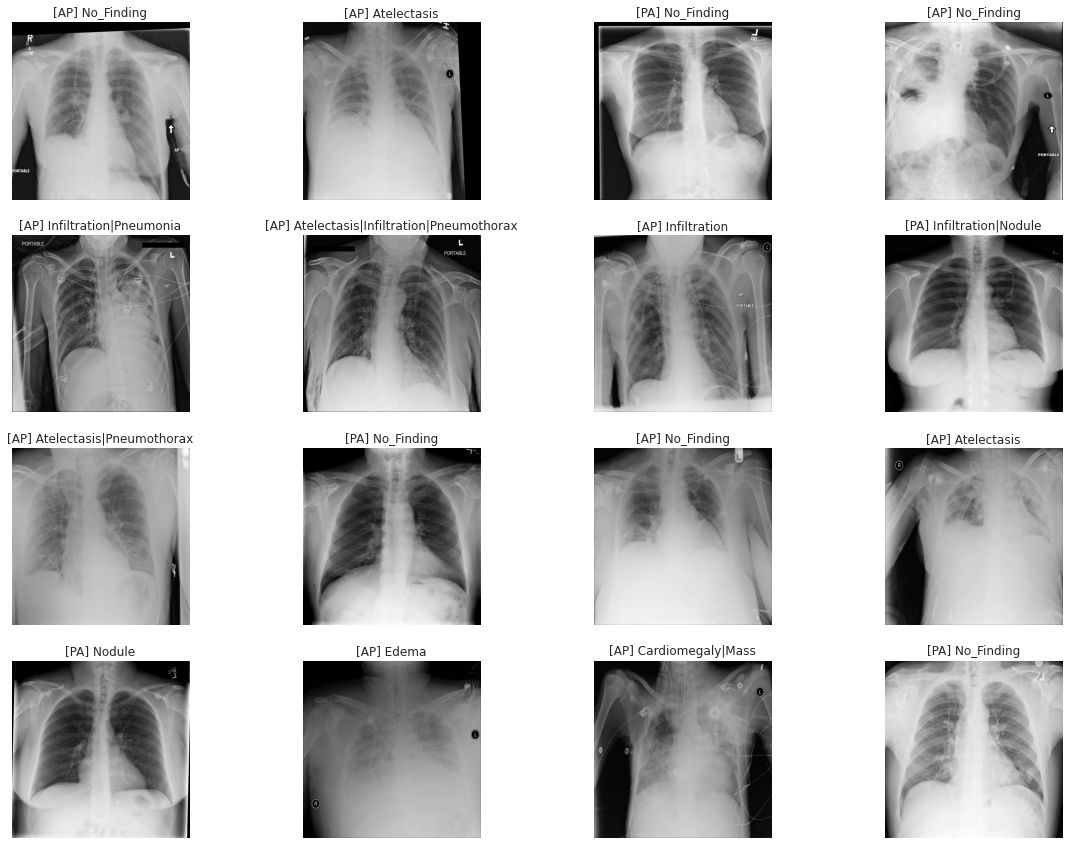

In [53]:
n_images_visualize = 16
sample = all_xray_df.sample(n_images_visualize)
all_images = []

def make_label(x):
    label = f"[{x['View_Position']}] "
    finding = []
    for c in c_findings:
        if x[c]: finding.append(c.replace('Finding_',''))
    label += '|'.join(finding)

    return label


rows = int(np.floor(np.sqrt(n_images_visualize)))
cols = int(n_images_visualize//rows)
fig = plt.figure(figsize=(20,15))

for i in range(1, rows*cols+1):
  fig.add_subplot(rows, cols, i)
  filename  = sample['dir'].iloc[i-1]
  filename += sample['Image_filename'].iloc[i-1]
  
  image = io.imread(filename)
  all_images.append(image)
  
  plt.imshow(image, cmap='gray')
  plt.title(make_label(sample.iloc[i - 1]))
  plt.axis(False)
  fig.add_subplot


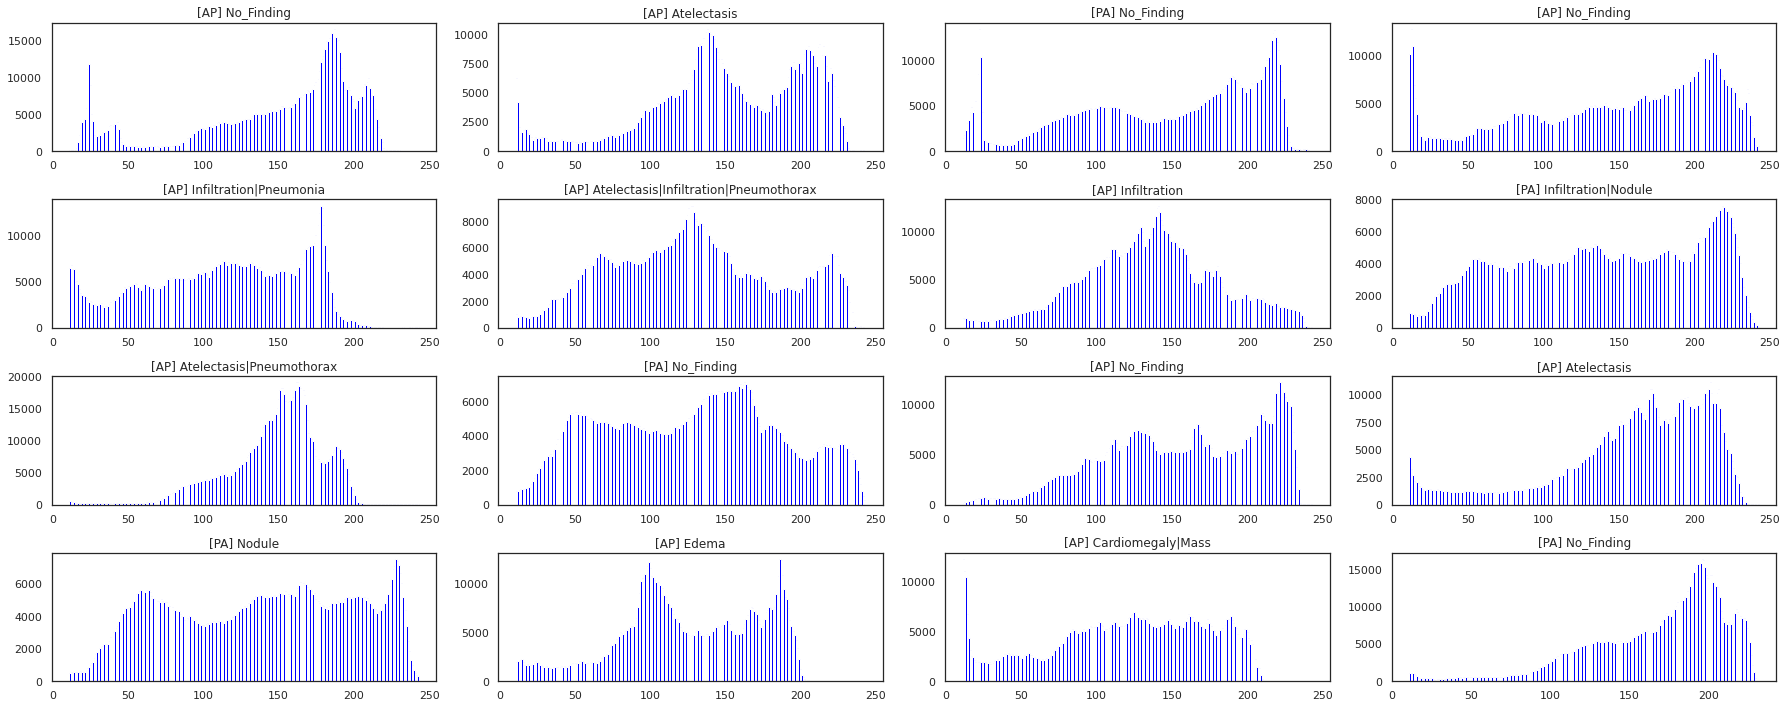

In [54]:
n_images_visualize = 16

rows = int(np.floor(np.sqrt(n_images_visualize)))
cols = int(n_images_visualize//rows)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 10))

upper_thresh = 244
low_thresh = 10
for i in range(rows):
  for j in range(cols):
    img_mask = (upper_thresh > all_images[i * cols + j]) & (all_images[i * cols + j] > low_thresh)
    ax[i, j].hist(all_images[i * cols + j][img_mask].ravel(), bins=256, color='blue')
    ax[i, j].set_title(make_label(sample.iloc[i * cols + j]))
    
    
plt.tight_layout()
plt.show()

#### Now let us try to find the distribution of AP (Anterior to Posterior) 
In order to do so, let us group about 100 pictures together and check its distribution. (we will use threshold, to avoid getting all the black and corners from the images)

100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


Mode of the distribution for AP is: [108] 


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

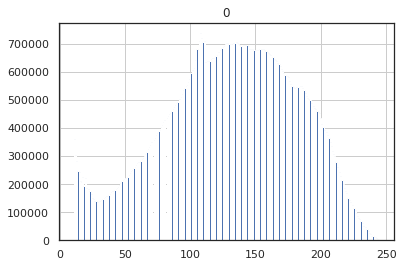

In [55]:

n_pictures = 100

all_images = all_xray_df.loc[all_xray_df.View_Position == 'AP'].sample(n_pictures)
low_thresh = 10
upper_thresh = 245
ap_images = []
for i in tqdm(range(len(all_images)), total=len(all_images)):
  
  image = io.imread(all_images.iloc[i]['dir'] + all_images.iloc[i]['Image_filename'])
  img_mask = (upper_thresh > image) & (image > low_thresh)

  ap_images.extend(image[img_mask].ravel().tolist())
    
ap_images = np.array(ap_images)

ap_mode = scipy.stats.mode(ap_images)[0]
print(f'Mode of the distribution for AP is: {ap_mode} ')
pd.DataFrame(ap_images).hist(bins=256)

#### Now let us try to find the distribution of PA (Posterior to Anterior) 
In order to do so, let us group about 100 pictures together and check its distribution. (we will use threshold, to avoid getting all the black and corners from the images)

100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


Mode of the distribution for AP is: [222] 


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

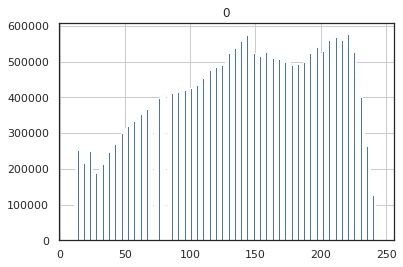

In [56]:
n_pictures = 100

all_images = all_xray_df.loc[all_xray_df.View_Position == 'PA'].sample(n_pictures)
low_thresh = 10
upper_thresh = 245
ap_images = []
for i in tqdm(range(len(all_images)), total=len(all_images)):
  
  image = io.imread(all_images.iloc[i]['dir'] + all_images.iloc[i]['Image_filename'])
  img_mask = (upper_thresh > image) & (image > low_thresh)

  ap_images.extend(image[img_mask].ravel().tolist())
    
ap_images = np.array(ap_images)

ap_mode = scipy.stats.mode(ap_images)[0]
print(f'Mode of the distribution for AP is: {ap_mode} ')
pd.DataFrame(ap_images).hist(bins=256)


#### Now let us try to find the distribution of a non-Diseased Patient
In order to do so, let us group about 100 pictures together and check its distribution. (we will use threshold, to avoid getting all the black and corners from the images)

100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Mode of the distribution for AP is: [138] 


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

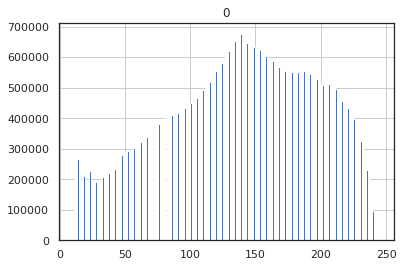

In [57]:

n_pictures = 100

all_images = all_xray_df.loc[all_xray_df.Finding_No_Finding == 1].sample(n_pictures)
low_thresh = 10
upper_thresh = 245
ap_images = []
for i in tqdm(range(len(all_images)), total=len(all_images)):
  
  image = io.imread(all_images.iloc[i]['dir'] + all_images.iloc[i]['Image_filename'])
  img_mask = (upper_thresh > image) & (image > low_thresh)

  ap_images.extend(image[img_mask].ravel().tolist())
    
ap_images = np.array(ap_images)

ap_mode = scipy.stats.mode(ap_images)[0]
print(f'Mode of the distribution for AP is: {ap_mode} ')
pd.DataFrame(ap_images).hist(bins=256)


#### Now let us try to find the distribution of a Diseased Patient
In order to do so, let us group about 100 pictures together and check its distribution. (we will use threshold, to avoid getting all the black and corners from the images)

100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Mode of the distribution for AP is: [142] 


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

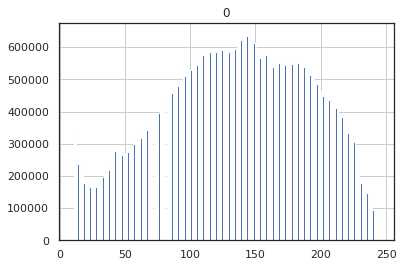

In [58]:
n_pictures = 100

all_images = all_xray_df.loc[all_xray_df.Finding_No_Finding != 1].sample(n_pictures)
low_thresh = 10
upper_thresh = 245
ap_images = []
for i in tqdm(range(len(all_images)), total=len(all_images)):
  
  image = io.imread(all_images.iloc[i]['dir'] + all_images.iloc[i]['Image_filename'])
  img_mask = (upper_thresh > image) & (image > low_thresh)

  ap_images.extend(image[img_mask].ravel().tolist())
    
ap_images = np.array(ap_images)

ap_mode = scipy.stats.mode(ap_images)[0]
print(f'Mode of the distribution for AP is: {ap_mode} ')
pd.DataFrame(ap_images).hist(bins=256)


#### Check all the distribution for each of the diseases
In order to do so, let us isolate the sampling for the exclusive disease. By taking only images with exclusive diseases to try to identify the specification of the distribution for the specific disease

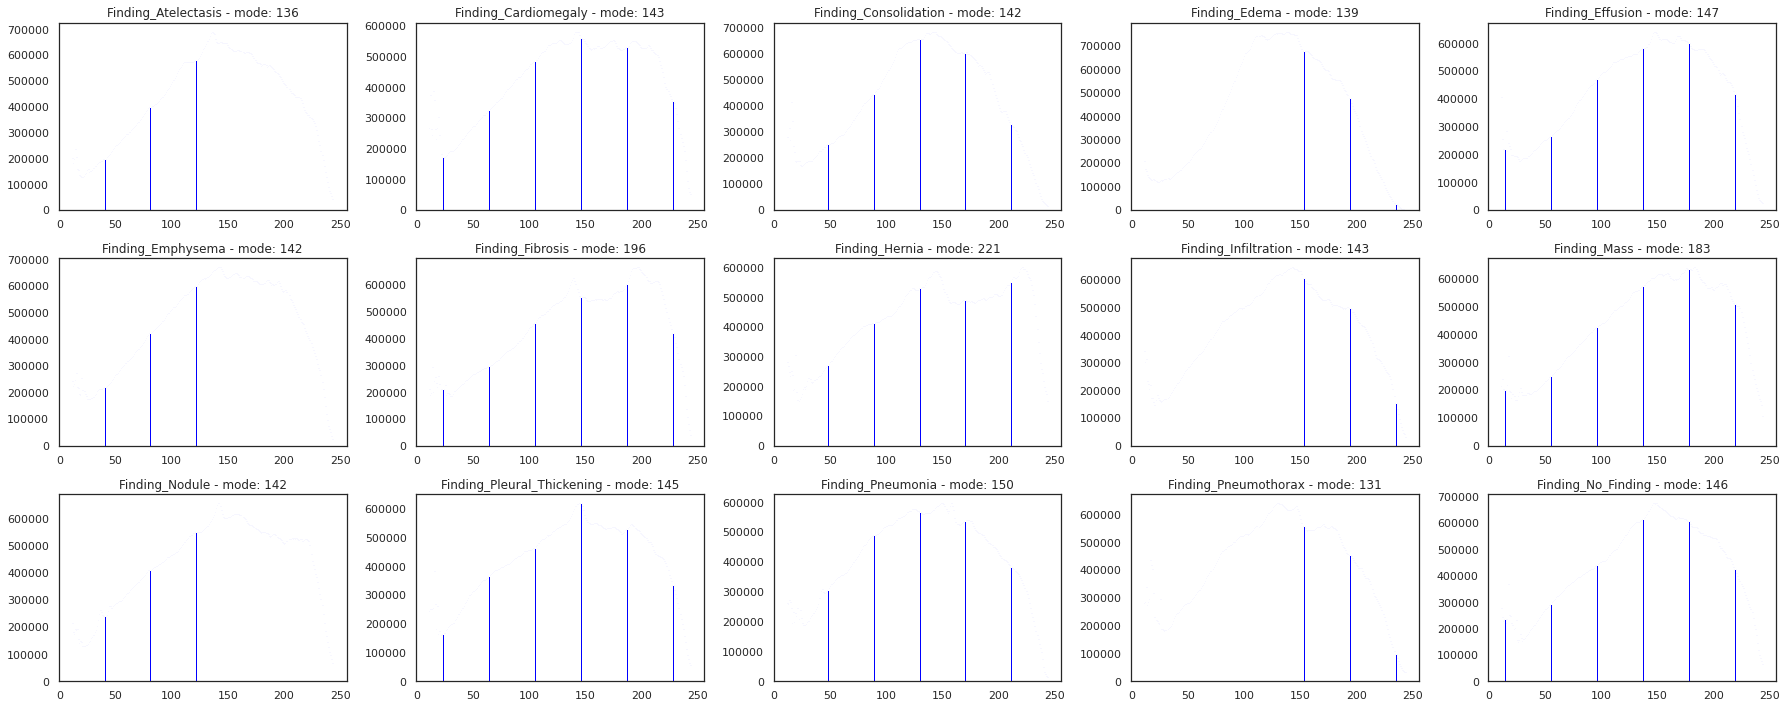

In [59]:
def get_images(df, low_thresh = 10, upper_thresh = 245, n_pictures = 100):
  all_images = df.sample(n_pictures)
  ap_images = []
  for i in range(len(all_images)):
    
    image = io.imread(all_images.iloc[i]['dir'] + all_images.iloc[i]['Image_filename'])
    img_mask = (upper_thresh > image) & (image > low_thresh)

    ap_images.extend(image[img_mask].ravel().tolist())
      
  ap_images = np.array(ap_images)

  return ap_images

n_images_visualize = len(c_findings)
rows = int(np.floor(np.sqrt(n_images_visualize)))
cols = int(n_images_visualize//rows)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 10))

for i in range(rows):
  for j in range(cols):

    tmp_df = all_xray_df.loc[(all_xray_df[c_findings[i * cols + j]] == 1) & (all_xray_df['n_diseases'] == (1 if c_findings[i * cols + j] != 'Finding_No_Finding' else 0)) ]

    imgs = get_images(tmp_df)
    ap_mode = scipy.stats.mode(imgs)[0][0]

    ax[i, j].hist(imgs, bins=256, color='blue')
    ax[i, j].set_title(c_findings[i * cols + j]  + f' - mode: {ap_mode}')
    
    
plt.tight_layout()
plt.show()

## Outcome of **EDA**

### **Data Corrections**

- Discarded **432 images**, representing *0.38% of total DB* (consisting of images which were *Inverted, Not Frontal* and badly *Rotated*, representing 14.35%, 73.84%, 11.81% respectively of bad labels); Only 2 images with pneumonia, so we didn't loose much data;
- Corrected Ages between 148 and 414 years old by taking existing ages, or doing averaging according to diseases;

### **Analysis**:

#### - *General*

  - **30,805** different patients (with a total of *112,295 images*); After discarding bad images, we keep **30,773 Patients** (removing 320 Patients, 0.10% of the patients);
  - Most of the patients (57%) have only 1 X-ray image for the case, and 81,32% of the patients have up to 4 x-rays; The rest 18.68% compromise the range from 5 - 182 X-rays per Patient; (no duplicates found)

#### - *Age*
 

 - Ages range from 1 to 95 year-old, with a mean of 47 years old;
 - 25% of images are of patients up to 35 year old;
 - 75% of images are of patients up to 59 year old;
 - There **isn't a significant difference from male vs female**, the difference is [1.38%, -2.94%, 4%, 3.33%] respectively in the buckets of [mean, 25%, 50%, 75%];
 - We can see a *slight increase of the distribution of Age of Patients with Disease vs Patients without Disease*. Concretely our mean increases by **5.98%**;
 - **Patients with Hernia have are generally much older** than Patients with no disease or with other Diseases (*25-41% older in average* than other diseases or no disease) having a minimum age of 16 year old vs in average other diseases of 1-2 year old (except Emphysema where minimum age is 10);
 - On the younger side, **Patients with Pneumonia, are generally younger**; The difference is not as significant as the Hernia, but we would still be talking about a *difference of 2 to 29% younger* than other diseases;

#### - *Gender*


  - This study as a **split between 46% vs 54% of Female vs Male** (respectively) of Patients, however if we look into the amount of images, then we get that the split is slightly bigger for Male at 56% vs 44% (which leads us to believe that Males Patient have more Images per case;
  - As mentioned before, Gender seems to be nearly evenly in terms of Ages;
  - **Emphysema is the Disease with the biggest gap (28%) between Male vs Female count**, with Males having 64% of the disease vs 36% of Females;
  - Most of the **Diseases are dominated by Men, however that is likely due to the fact that our data contains mostly men** (as mentioned before 54% vs 46%), however there are 2 curious diseases which have predominantly female patients: Cardiomegaly (6% more than men) and Hernia (15% more than men); Another 2 diseases are also worth mentioning Edma and Pneumothorax, given that Men are predominantly with 5% and 2% more than Female, however these percentages are fewer than the distribution of the Database;
  - **Pneumonia** also has a big gap between Men vs Women, with **Men having 17% more images** than women.

#### - *Diseases*


  - The Data consists of approximately **54% of no diseases, versus 46% of images containing any disease**.
  - **Infiltration, Effusion and Atelectasis are the most common diseases** found in images, representing (18%, 12% and 10% respectively or 25%, 16%, 14% of disease only);
  - Interestingly, **Hernia accounts only for 227 images** (0,38% of images), which might explain why in our dataset, there is such a big difference between Men vs Women (as mentioned above Women have 15% more images than Men). Meaning in the real world, the proportion of Men vs Women can be very different;
  - Same for our findings regarding **Age and Pneumonia** (where we saw that age is younger than other diseases)
  - From the correlation, we take that the **2 diseases which are more linked together are Effusion and Atelectasis** (with a 0.5 Pearson correlation factor);
  - Besides that we can also find with a 0.4 Pearson Correlation factor the combinations of: *Effusion and Consolidation; Infiltration and Effusion; Consolidation and Atelectasis; Pneumothorax and Emphysema*;
  - The **closest disease to Pneumonia is Edma** with a 0.3 Pearson Correlation factor;

#### - *Image Analysis*


  - We have 2 different types of X-rays: PA (which stands for Posterior to Anterior image), representing 67,387 out 112,295 (60%); and AP (which stands for Posterior to Anterior image), representing 44,908 out 112,295 (40%);
  — We can see a sample of 16 images and it's distribution, we see a big variety in pictures distribution, so let us try to isolate certain characteristics of the images (example, view-point and different diseases);
  - Initially we tried to check the mean distribution and graphic of distribution for AP and PA view-points. In order to do that, we combined 100 images and defined a lower and upper threshold, in order for it not to be too influenced by the white and black frames of the pictures. Although the mean is close to each other (143 and 146), the distribution plot shows considerate difference (example there's a deep in the lower values of AP view points, not visible in PA; as well as the deepening of the curve from 200 to 255 pixels is much more accentuated in AP than in PA); 
  - Trying the same as above point for a disease free sample images vs a disease sample images, we don't see an immediate difference (mean 144 vs 140 and visually we don't see a big difference);
  - Given that we can't see a big difference between the last point, I tried to drill down into each specific disease, isolating the disease itself (avoiding images which present more than one disease). The result improved significantly, by isolating each disease we can see a clear difference from distribution for each of the diseases; Concretely we can see that mean ranges from 112 (people with Edema) to 199 (people with Fibrosis);
  - With the distribution analysis of each disease we can observe again that there are still some diseases which are fairly close to each other in distribution, meaning that potentially they will be hard to differentiate; Example of Effusion and Consolidation as mentioned above have the closest Pearson correlation value (0.5) their distribution looks very alike and have a mode of 140 and 144, which is relatively close;
  - Regarding **Pneumonia, distribution, it is unfortunately close to No Disease**, 150 mean to 146 mean respectively;

## Conclusions EDA

- Out of what we analysed, I believe if it was to do classification for all the 14 diseases, it would be hard to do multi-classification with one model only;
- as we saw from the distribution, given that there are some close similarities images alone won't be enough for a fast converging, so we might want to add info to the model such as age, gender, ...;
- the range of values from **Image information is a int from 0-255** (intensity of light), for our model, we will need to normalize this number so the model can handle it easier;
- Idealy we would have enough cases of each class, however as we can see from the EDA, we have a clear Data Inbalance Issue, where even our highest occuring disease (Infiltration) has only 18% of occurence in our database, (meaning  the model will have an higher incentive to predict non-diseases than any disease);In order to try to overcome that, we will use "stratify" mode to split diseases accordingly;
- Our **images are considerably big**... as you can see from the printed examples, in order to make the model faster and workable, we will need to **standardize the images** to make them all smaller and same size (something like 224 x 224 should be fine);
- As we can see from the few displayed images, and as we empirically can figure it out, the **x-rays are not always taken into the same position**, so will be helpfull to do some image augmentation;
- Given that our model is a **binary classification to identify Pneumonia**, we will have an **issue with imbalence classes**. As we've seen from the EDA, we only have 1,429 Pneumonia vs 60,190 of No Diseases;
- To try to mitigate the previous point, we will try to do **Image augmentation that will turn the 1429 images of Pneumonia into more** via augmentation through out our epochs;
- We can't leave training with the same proportion of No Pneumonia and Pneumonia as our DataSet, because if we do so, we will a model with a high tendency to predict No Pneumonia, given that will give a much higher score. So what we will do is have our training set with 50-50% split and for our Validation we will leave it close to real-world, with a difference of 5x No-Pneumonia to Pneumonia;

In [60]:
all_xray_df['path'] = all_xray_df['dir'] + all_xray_df['Image_filename']
all_xray_df = all_xray_df.drop(['dir', 'size', 'Patient_Gender_cat'], axis=1)
all_xray_df.to_csv(ROOT_CSV + 'Data_Entry_2017_EDA.csv', index=False)

In [61]:
all_xray_df.head(5)

,Image_filename,Follow-up,Patient_ID,Patient_Age,Patient_Gender,View_Position,Image_width,Image_height,ImagePixelSpacing_x,ImagePixelSpacing_y,...,Finding_Hernia,Finding_Infiltration,Finding_Mass,Finding_No_Finding,Finding_Nodule,Finding_Pleural_Thickening,Finding_Pneumonia,Finding_Pneumothorax,n_diseases,path
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,1,/data//images_001/images/00000001_000.png
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,0,0,0,0,0,0,0,0,2,/data//images_001/images/00000001_001.png
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0,0,0,0,0,0,0,0,2,/data//images_001/images/00000001_002.png
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0,0,0,1,0,0,0,0,0,/data//images_001/images/00000002_000.png
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,1,0,0,0,0,0,0,0,1,/data//images_001/images/00000003_000.png
